In [1]:
#Creates the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Copies the kaggle.json API key file to the .kaggle directory
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
# Imports the Google Colab drive module and mounts your Google Drive to the Colab environment at the specified path

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Downloads the "dogs-vs-cats" dataset from Kaggle

!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:49<00:00, 23.3MB/s]
100% 1.06G/1.06G [00:49<00:00, 23.1MB/s]


In [4]:
# Extracting dataset files from the downloaded zip

import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Importing Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [6]:
# Defines a Sequential model for data augmentation that applies random horizontal flips and random rotations (up to 10%) to the images

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])


In [7]:
# Generators
train_data=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds=keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [8]:
# Print the train dataset to check if it has loaded properly

print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


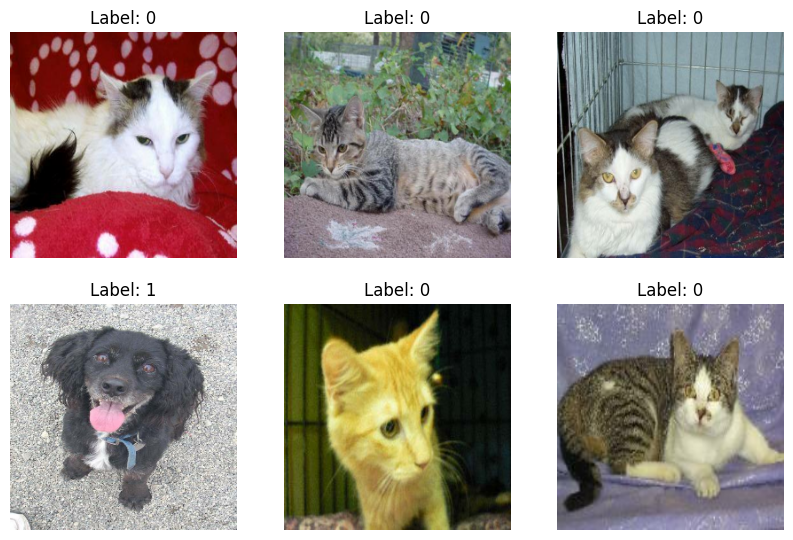

In [9]:
# Get a batch of images and labels from the train dataset
image_batch, label_batch = next(iter(train_data))

# Display 6 images
num_images = 6
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Label: {label_batch[i].numpy()}")
    plt.axis("off")

plt.show()

In [10]:
# Print the validation dataset to check if it has loaded properly

print(validation_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


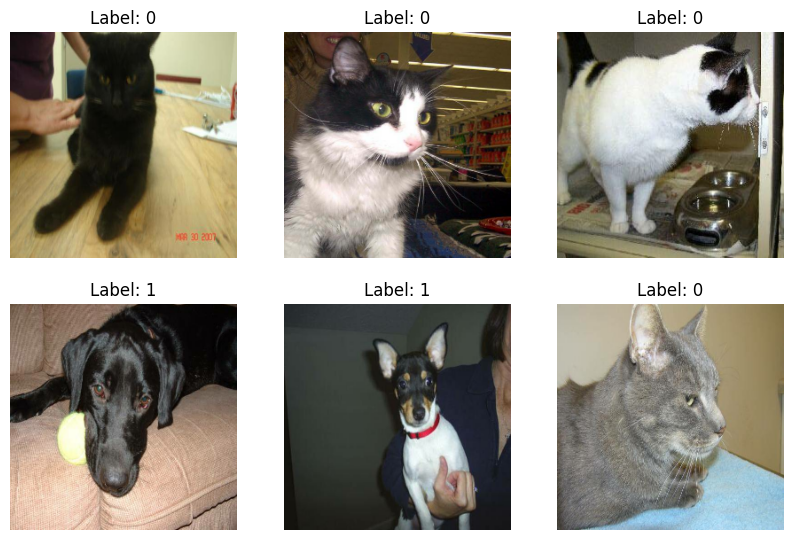

In [11]:
# Get a batch of images and labels from the validation dataset
image_batch, label_batch = next(iter(validation_ds))

# Display 6 images
num_images = 6
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Label: {label_batch[i].numpy()}")
    plt.axis("off")

plt.show()

**The labels (Label: 0 and Label: 1) indicate the class of each image:**

Label: 0 → Likely represents cats.

Label: 1 → Likely represents dogs.

In [12]:
# Normalize Data
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))  # Apply Augmentation
train_data = train_data.map(process)
validation_ds = validation_ds.map(process)

In [13]:
 # Create CNN Model

In [14]:
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Displays the summary of the model architecture

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,821,313 (26.02 MB)

 Trainable params: 6,820,353 (26.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
# Compiling the model with optimizer, loss, and metrics

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
# Sets early stopping based on validation accuracy with patience of 3 epochs

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [18]:
# Reduces learning rate on plateau of validation loss with a factor of 0.2

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [19]:
# Training the CNN model using training data

history=model.fit(train_data,epochs=50,validation_data=validation_ds,callbacks=[early_stopping,reduce_lr])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 242s 366ms/step - accuracy: 0.6057 - loss: 0.7618 - val_accuracy: 0.6902 - val_loss: 0.5565 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 245s 353ms/step - accuracy: 0.6748 - loss: 0.5846 - val_accuracy: 0.7096 - val_loss: 0.5501 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 347ms/step - accuracy: 0.7117 - loss: 0.5349 - val_accuracy: 0.7614 - val_loss: 0.5012 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 352ms/step - accuracy: 0.7408 - loss: 0.5080 - val_accuracy: 0.7626 - val_loss: 0.4884 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 348ms/step - accuracy: 0.7699 - loss: 0.4719 - val_accuracy: 0.8034 - val_loss: 0.4224 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 345ms/step - accuracy: 0.7906 - loss: 0.4500 - val_accuracy: 0.8352 - val_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 

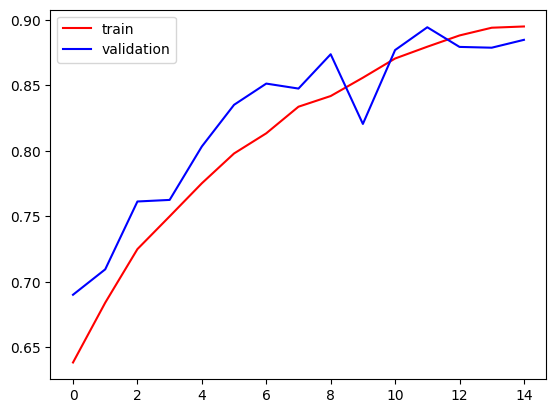

In [20]:
# Plots training and validation accuracy with legends

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

* The graph indicates good model performance since training and validation accuracy are close to each other, and validation accuracy does not decrease significantly.

* The absence of a large gap between the two lines suggests that the model has not overfitted to the training data.

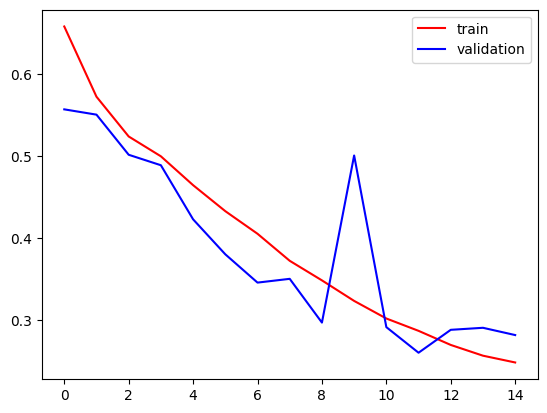

In [21]:
# Plotting training and validation loss

import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

* Positive Indicators: Both training and validation loss decrease overall, indicating the model is learning effectively and generalizing well.

* Fluctuations: The temporary increase in validation loss (spike) may indicate the model faced challenges generalizing at those points but recovered after further training.

**Prediction on new unseen data**

In [45]:
import cv2

**Dog image**

In [46]:
# Read the image

test_img=cv2.imread('/content/Dog.jpg')

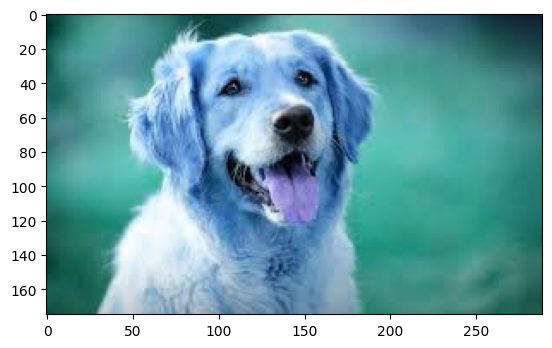

In [47]:
# Display the image using Matplotlib

plt.imshow(test_img)

In [48]:
# Check the dimensions of the image (height, width, channels)

test_img.shape

(175, 289, 3)

In [49]:
# Resize the input image to 256x256 pixels

test_img=cv2.resize(test_img,(256,256))

In [50]:
# Reshape the image to add an extra dimension for batch size (1, 256, 256, 3) for model input

test_input=test_img.reshape((1,256,256,3))

In [51]:
# Predict the output using the trained model for the input image

model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[1.]], dtype=float32)

**Cat image**

In [52]:
# Read the image

test_image=cv2.imread('/content/Cat.jpg')

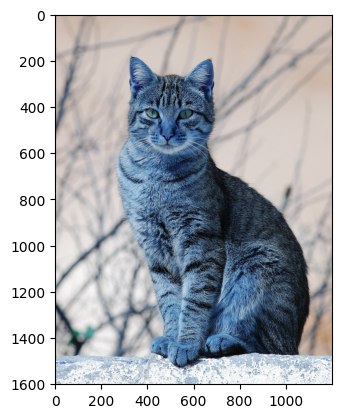

In [53]:
# Display the image using Matplotlib

plt.imshow(test_image)

In [54]:
# Check the dimensions of the image (height, width, channels)

test_image.shape

(1602, 1200, 3)

In [55]:
# Resize the input image to 256x256 pixels

test_image=cv2.resize(test_image,(256,256))

In [56]:
# Reshape the image to add an extra dimension for batch size (1, 256, 256, 3) for model input

test_input=test_image.reshape((1,256,256,3))

In [57]:
# Predict the output using the trained model for the input image

model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[0.]], dtype=float32)

Label: 0 → Likely represents cats.

Label: 1 → Likely represents dogs.